<a href="https://colab.research.google.com/github/StevenAlvaradoAguilar/Codigo_Clases_IA/blob/main/C3_Faces_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 - GAN Tutorial. 
## Working with TPUs and CelebA Dataset. 

In this notebook we use the CelebA Dataset to create a GAN who can be trained using the TPUs and distributed strategy. 

At the end we wil have a GIF generated with the proces of generating faces from the beginnig to the end. 

## Imports

In [ ]:
# install tensorflow_addons necesary to use TPUs and distributed strategy. 
#!pip install -U tensorflow-addons

#Model face detection library, we can use the face detection in the notebooks. 
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import libraries
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
import tensorflow.keras as keras
from IPython import display

import os
import zipfile
import glob
import urllib.request
from enum import Enum
from tqdm import tqdm
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from IPython.display import display
from IPython.display import Image as IpyImage
import imageio
import cv2

In [ ]:
#Face detection library
import mtcnn
print(mtcnn.__version__)

0.1.0


In [ ]:
#Support function to print the images. 
def plot_results(images, n_cols=None, unnorm=True, save_path = "" ):

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(12, 12))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        imageorg = image

        #We can print normalized and unnormalized images, just using the unnorm parameter. 
        if unnorm:
          imageorg = (image +1) * 0.5
          
        plt.imshow(imageorg)
        plt.axis("off")

        if save_path:
          plt.savefig(save_path)
    plt.show()
    

## Setup TPU

Wer are going to use the TPU and a distributed strategy. Sometimes you can't get a TPU available at Colab. I'm sorry but this notebook is prepared to work with TPU's. 

Just wait for a free TPU or Get Colab Pro. 


In [ ]:
try: 
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError: 
  raise BaseException("CAN'T CONNECT TO A TPU")

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

## Download and Prepare the Dataset

Thist dataset is available from multiple sources. I'm used to use it hosted in Google Colab, but no one garatees that it will be available forever. 

Oter sources are: 
Kaggle: 
https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

mmlab: 
https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

and keras
https://www.tensorflow.org/datasets/catalog/celeb_a?hl=es-419

In [ ]:
# make a data directory
try:
  os.mkdir('/tmp/celeb')
except OSError:
  pass

# download the dataset archive
data_url = "https://storage.googleapis.com/learning-datasets/Resources/archive.zip"
data_file_name = "archive.zip"
download_dir = '/tmp/celeb/'
urllib.request.urlretrieve(data_url, data_file_name)

# extract the zipped file
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

We have two functions to load the faces. One of them use the library MTCNN to detect where the face is. The proble is taht is really time consuming. But I mantained the function just in case you want to know how it works and if you want test how the GAN works when we detect where the faces are. 

In [ ]:
#Function to load the faces. 
#Crop & center the images because the faces is almost always in the center. 
def load_faces(image_paths, resize, max_images):
  crop_size = 128
  if (max_images == 0): 
    max_images =  len(image_paths)
    print(max_images)

  images = np.zeros((max_images, resize, resize, 3), np.uint8)

  for i, path in tqdm(enumerate(image_paths)):
    with Image.open(path) as img:
      left = (img.size[0] - crop_size) // 2
      top = (img.size[1] - crop_size) // 2
      right = left + crop_size
      bottom = top + crop_size
      img = img.crop((left, top, right, bottom))
      img = img.resize((resize, resize), Image.LANCZOS)
      images[i] = np.asarray(img, np.uint8)

      if (i >= max_images-1):
        break

  return images

In [ ]:
#Funtion to load the faces. Use the MTCNN lybrary to detect where the face is. 
def load_faces_MTCNN(image_paths, resize, max_images):
  MTCNN_model = mtcnn.MTCNN()
  if (max_images == 0): 
    max_images =  len(image_paths)
    print(max_images)

  images = np.zeros((max_images, resize, resize, 3), np.uint8)
  for i, path in enumerate(image_paths):
    with Image.open(path) as img:

      img = img.convert('RGB')
      #img_pixels = np.asarray(img)
      
      face = MTCNN_model.detect_faces(img_pixels)
      if len(face) == 0:
        continue 
      x1, y1, width, height = face[0]['box']
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height

      img = img.crop((x1, y1, x2, y2))
      img = img.resize((resize, resize), Image.LANCZOS)
      images[i] = np.asarray(img, np.uint8)
      if (i >= max_images-1):
        break
  return images


Now we are preparing the Dataset. Load the images and normalize the pixels. 

In [ ]:
#Load the pictures in the dataset. You can indicate the max_images. I recommend 
#that for testing you use 1000 images, and when you want to see the result final 
#use the max number of images, indicating 0 to max_images. 
def load_celeba(batch_size, resize=80, max_images=0):
  """Creates batches of preprocessed images from the JPG files
  Args:
    batch_size - batch size
    resize - size in pixels to resize the images
    crop_size - size to crop from the image
  
  Returns:
    prepared dataset
  """

  # initialize zero-filled array equal to the size of the dataset
  image_paths = sorted(glob.glob("/tmp/celeb/img_align_celeba/img_align_celeba/*.jpg"))
  
  print("Creating Images")

  # crop and resize the raw images then put into the array
  #choose wich function you want to use. 
  images = load_faces(image_paths, resize, max_images)
  #images = load_faces_MTCNN(image_paths, resize, max_images)
  
  #Plot the 5 first images. 
  plot_results(images[0:5], unnorm=False)

  # split the images array into two
  split_n = images.shape[0] // 2
  images1, images2 = images[:split_n], images[split_n:2 * split_n]
  del images

  # preprocessing function to convert the pixel values into the range [-1,1]
  #Is a GAN Hack to normalize the pixels of the images 
  def preprocess(img):
      x = tf.cast(img, tf.float32) / 127.5 - 1.0
      return x
  
  # use the preprocessing function on the arrays and create batches
  dataset = tf.data.Dataset.from_tensor_slices((images1, images2))
  dataset = dataset.map(
      lambda x1, x2: (preprocess(x1), preprocess(x2))
  ).shuffle(4096).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
  
  return dataset



8
Creating Images
202599


202598it [04:58, 678.87it/s]


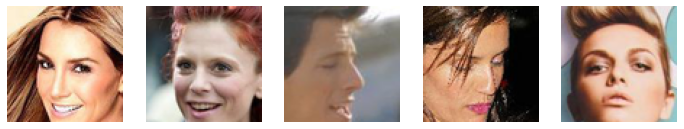

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
# use the function above to load and prepare the dataset
#Note how the batch_size is multiplied by strategy.num_replicas_in_sync
print(strategy.num_replicas_in_sync)
batch_size = 8
batch_size = batch_size * strategy.num_replicas_in_sync
dataset = load_celeba(batch_size, max_images=0)
out_dir = "celeba_out"

In [ ]:
    # create distributed dataset
    dataset = strategy.experimental_distribute_dataset(dataset)
    
    # set the loss function
    loss_func = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, 
        reduction=tf.keras.losses.Reduction.NONE
    )

## Build the Model

Time to construct the Generator and the Discriminator. We have two realy simple functions that can be used to create different generatos and discriminators. 

The most important is that we are workin with 80 x 80 x 3 images. And the generator must have an output of 80 x 80 x3. And the discriminator the same input and a boleean output. 


### Generator


In [ ]:
def adapt_generator(initial_0, nodes, upsamplings, multnodes = 1.0, endnodes = 3, input_noise=100):
  #initial_0, initial_1: size of the initial mini image. 
  #nodes: nodes in the first Dense layers. 
  #upsamplings: number og upsamplings bucles. 
  #multnodes: a multiplicator to modify the nodes in each upsampling bucle. 
  #endnodes: nodes of the last layer. 
  #input_noise: size of the noise. 

  model = keras.models.Sequential()

  #First Dense layer. 
  model.add(keras.Input(shape=(1, 1, 128)))

  #Upsampling bucles. 
  nodeslayers = nodes
  model.add(keras.layers.Conv2DTranspose(nodeslayers , kernel_size=initial_0, strides=1, padding="valid", 
                                 use_bias=False))

  
  for i in range(upsamplings-1):
    nodeslayers = int(nodeslayers * multnodes)
    model.add(keras.layers.Conv2DTranspose(nodeslayers , kernel_size=4, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)))
    model.add(keras.layers.BatchNormalization())

  #last upsample and last layer. 
  model.add(keras.layers.Conv2DTranspose(endnodes, kernel_size=4, strides=2, padding="SAME", 
                                 activation='tanh'))
  
  return model

### Discriminator


In [ ]:
def adapt_discriminator(nodes, downsamples, multnodes = 1.0, in_shape=[32, 32, 3]):
  #nodes: nodes in the first Dense layers.
  #downsamples: number of downsamples bucles. 
  #multnodes: a multiplicator to modify the nodes in each downsample bucle.
  #in_shape: Shape of the input image. 

  model = keras.models.Sequential()
  
  #input layer % first downsample 
  model.add(keras.layers.Conv2D(nodes, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=in_shape))
  model.add(keras.layers.Dropout(0.4))
  
  #creating downsamples
  nodeslayers = nodes
  for i in range(downsamples - 1):
    nodeslayers = int(nodeslayers * multnodes)
    model.add(keras.layers.Conv2D(nodeslayers, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.Dropout(0.4))
  
  #ending model
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1, activation="sigmoid"))
  
  return model

time to create the Generator and the Discriminator using the functions. 

In [ ]:
# Settings
resize = 80
shape = (resize, resize, 3)

# Build the GAN
with strategy.scope():
    # create the generator model
    model_G = adapt_generator(5, nodes=128, upsamplings=4, multnodes=1, endnodes=3, input_noise=100)

    # create the discriminator model
    model_D = adapt_discriminator(128, 5, multnodes=1, in_shape=shape)
    
    # print summaries
    model_G.summary()
    model_D.summary()

    # set optimizers
    param_G = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    param_D = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 5, 5, 128)        409600    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 10, 10, 128)      262272    
 ranspose)                                                       
                                                                 
 batch_normalization (BatchN  (None, 10, 10, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 20, 20, 128)      262272    
 ranspose)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 128)      5

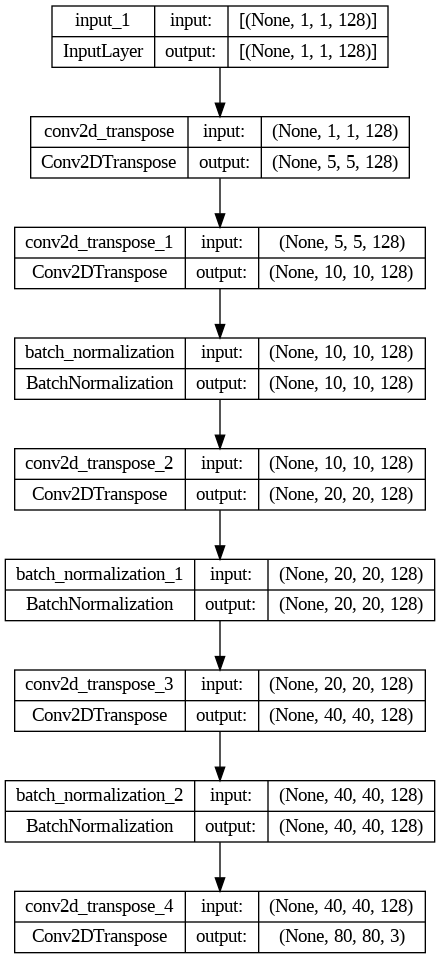

In [ ]:
plot_model(model_G, show_shapes=True, 
           show_layer_names=True)


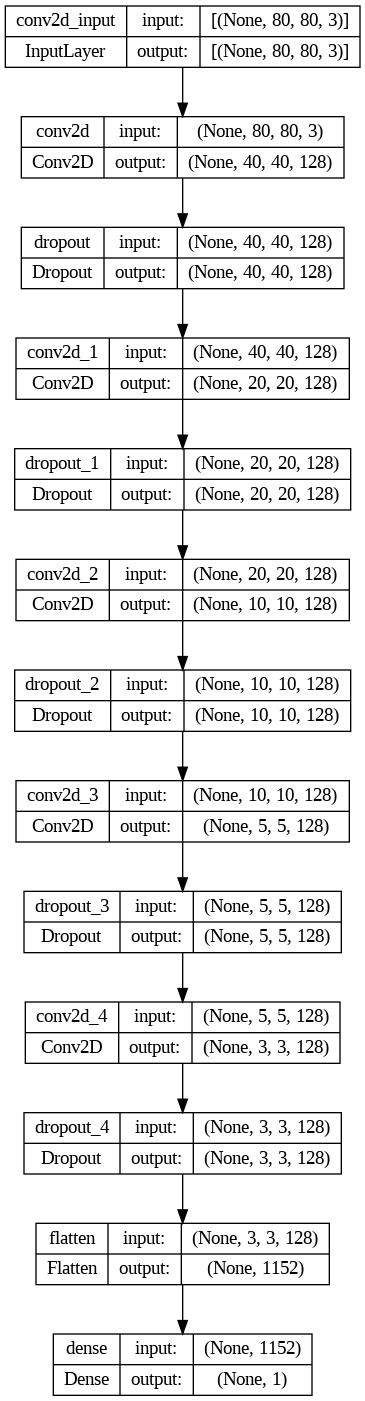

In [ ]:
plot_model(model_D, show_shapes=True, 
           show_layer_names=True)

## Training

Finally, we can train the model. 

In [ ]:
class Reduction(Enum):
    SUM = 0
    CONCAT = 1
#TThis decorated function indicates how to concatenate the values 
#returned by all the functions working in the different distributed 
#TPU's. 
#We have two possibilites. return a reducted SUM of each process, or 
# a concatenation. 
def distributed(*reduction_flags):
    def _decorator(fun):
        def per_replica_reduction(z, flag):
            if flag == Reduction.SUM:
                return strategy.reduce(tf.distribute.ReduceOp.SUM, z, axis=None)
            elif flag == Reduction.CONCAT:
                z_list = strategy.experimental_local_results(z)
                return tf.concat(z_list, axis=0)
            else:
                raise NotImplementedError()

        @tf.function
        def _decorated_fun(*args, **kwargs):
            fun_result = strategy.run(fun, args=args, kwargs=kwargs)

            assert type(fun_result) is tuple
            return tuple((per_replica_reduction(fr, rf) for fr, rf in zip(fun_result, reduction_flags)))
        return _decorated_fun
    return _decorator

This function defines the training on a given batch. It does the two-phase training discussed in class.
* First, you train the discriminator to distinguish between fake and real images.
* Next, you train the generator to create fake images that will fool the discriminator.

In [ ]:
@distributed(Reduction.SUM, Reduction.SUM, Reduction.CONCAT)
def train_on_batch(real_img1, real_img2):
    '''trains the GAN on a given batch'''
    # concatenate the real image inputs
    real_img = tf.concat([real_img1, real_img2], axis=0)

    # PHASE ONE - train the discriminator
    with tf.GradientTape() as d_tape:

        # create noise input
        z = tf.random.normal(shape=(real_img.shape[0], 1, 1, z_dim))

        # generate fake images
        fake_img = model_G(z)

        # feed the fake images to the discriminator
        fake_out = model_D(fake_img)

        # feed the real images to the discriminator
        real_out = model_D(real_img)

        # use the loss function to measure how well the discriminator
        # labels fake or real images
        d_fake_loss = loss_func(tf.zeros_like(fake_out), fake_out)
        d_real_loss = loss_func(tf.ones_like(real_out), real_out)

        # get the total loss
        d_loss = (d_fake_loss + d_real_loss) 
        d_loss = tf.reduce_sum(d_loss) / (batch_size * 2)

    # get the gradients
    gradients = d_tape.gradient(d_loss, model_D.trainable_variables)
    
    # update the weights of the discriminator
    param_D.apply_gradients(zip(gradients, model_D.trainable_variables))
    

    # PHASE TWO - train the generator
    with tf.GradientTape() as g_tape:
        # create noise input
        z = tf.random.normal(shape=(real_img.shape[0], 1, 1, z_dim))
        
        # generate fake images
        fake_img = model_G(z)

        # feed fake images to the discriminator
        fake_out = model_D(fake_img)
        
        # use loss function to measure how well the generator
        # is able to trick the discriminator (i.e. model_D should output 1's)
        g_loss = loss_func(tf.ones_like(fake_out), fake_out)
        g_loss = tf.reduce_sum(g_loss) / (batch_size * 2)
    
    # get the gradients
    gradients = g_tape.gradient(g_loss, model_G.trainable_variables)

    # update the weights of the generator
    param_G.apply_gradients(zip(gradients, model_G.trainable_variables))
    
    # return the losses and fake images for monitoring
    return d_loss, g_loss, fake_img 

This will start the training loop. We set the number of epochs but feel free to revise it. From initial runs, it takes around 50 seconds to complete 1 epoch. We've setup a progress bar to display the losses per epoch and there is code as well to print the fake images generated.

[Epoch 0]: : 1581it [00:38, 42.89it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 0]: : 1582it [00:38, 40.76it/s]


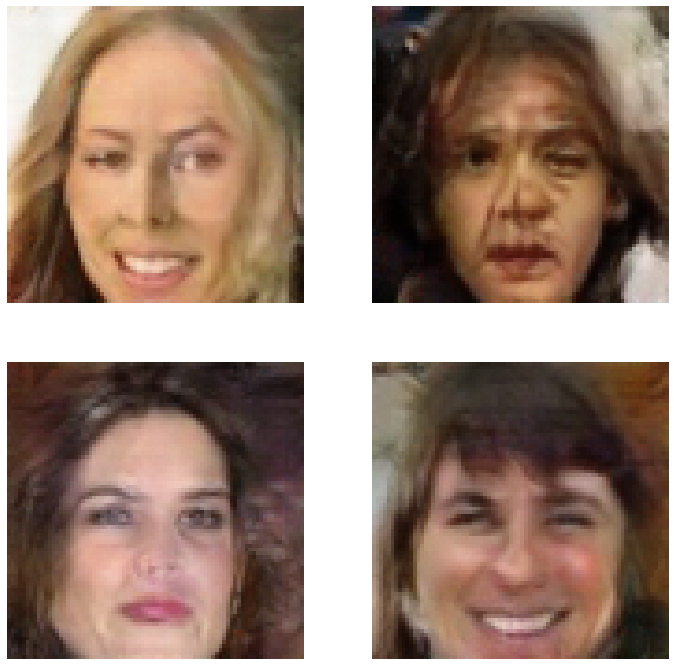

[Epoch 1]: : 1581it [00:39, 44.42it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 1]: : 1582it [00:39, 39.70it/s]


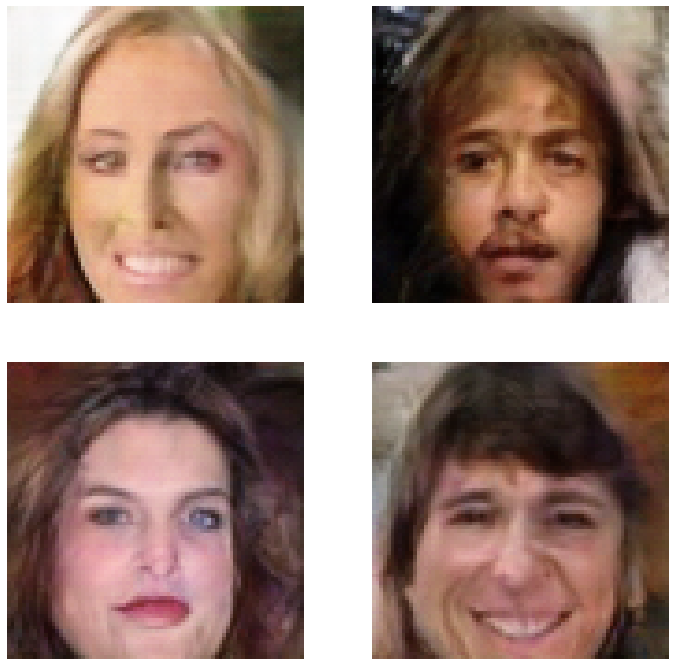

[Epoch 2]: : 1581it [00:38, 43.68it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 2]: : 1582it [00:38, 40.62it/s]


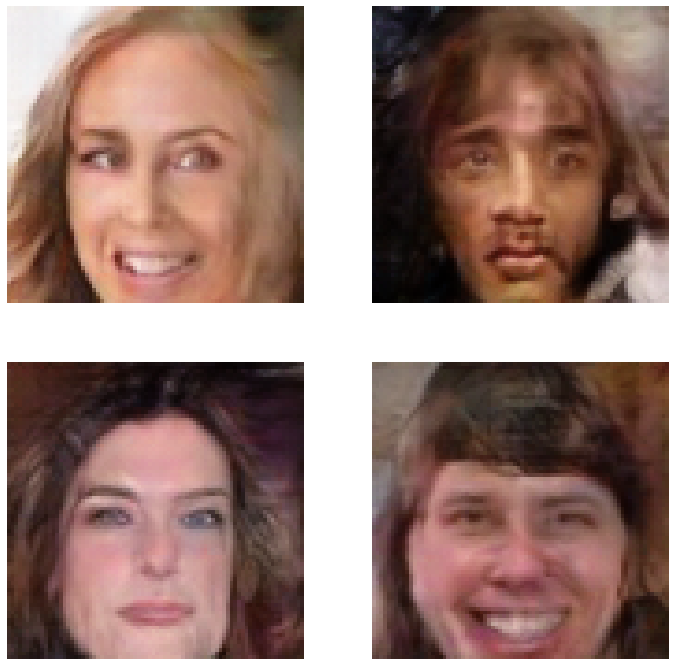

[Epoch 3]: : 1581it [00:38, 43.85it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 3]: : 1582it [00:38, 40.78it/s]


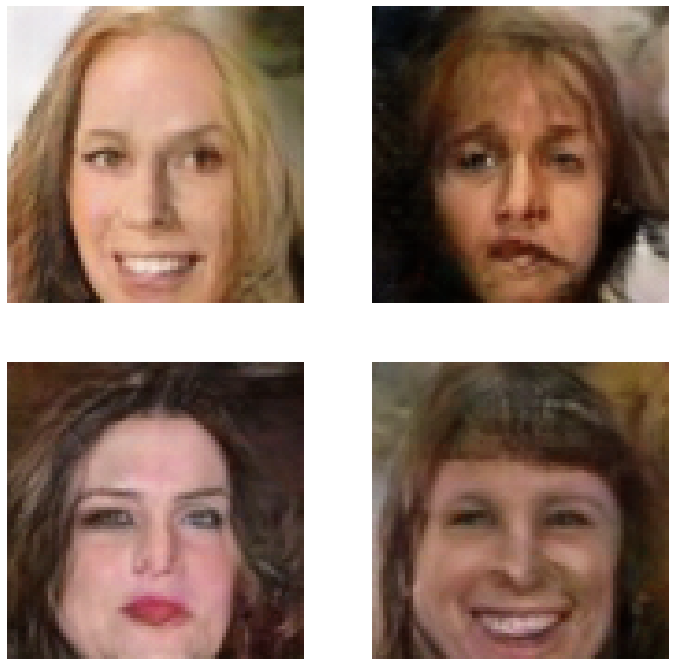

[Epoch 4]: : 1581it [00:38, 43.20it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 4]: : 1582it [00:38, 40.67it/s]


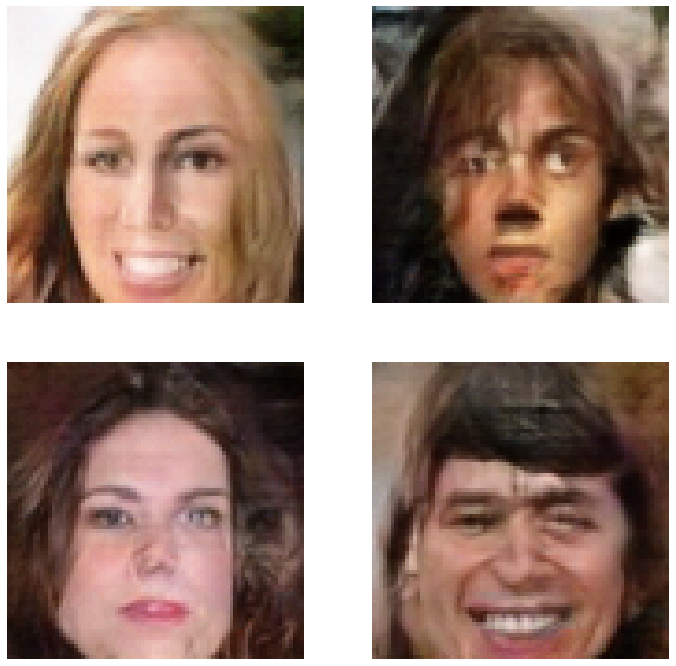

[Epoch 5]: : 1581it [00:38, 44.64it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 5]: : 1582it [00:38, 40.65it/s]


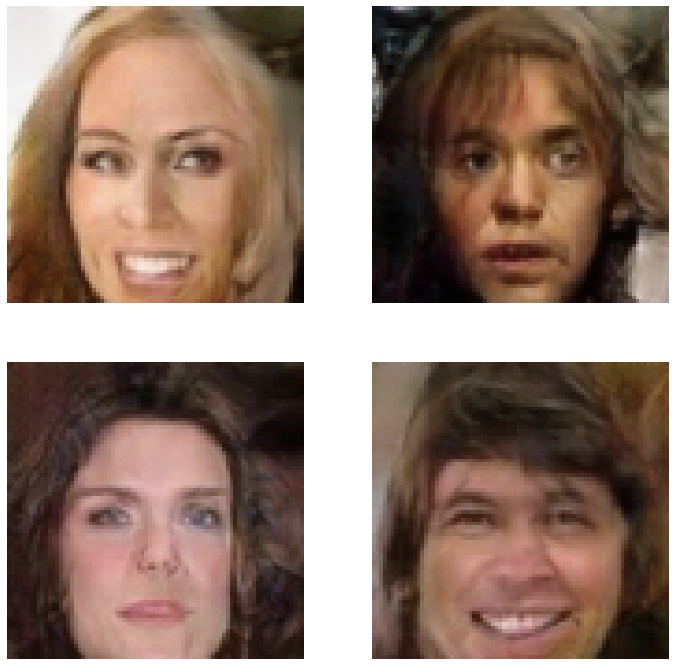

[Epoch 6]: : 1581it [00:39, 43.31it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 6]: : 1582it [00:39, 40.40it/s]


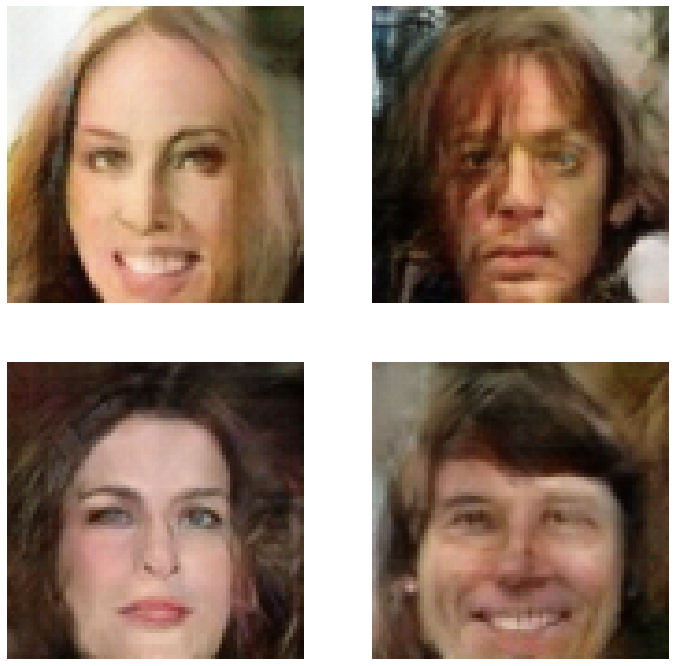

[Epoch 7]: : 1581it [00:39, 44.22it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 7]: : 1582it [00:39, 40.43it/s]


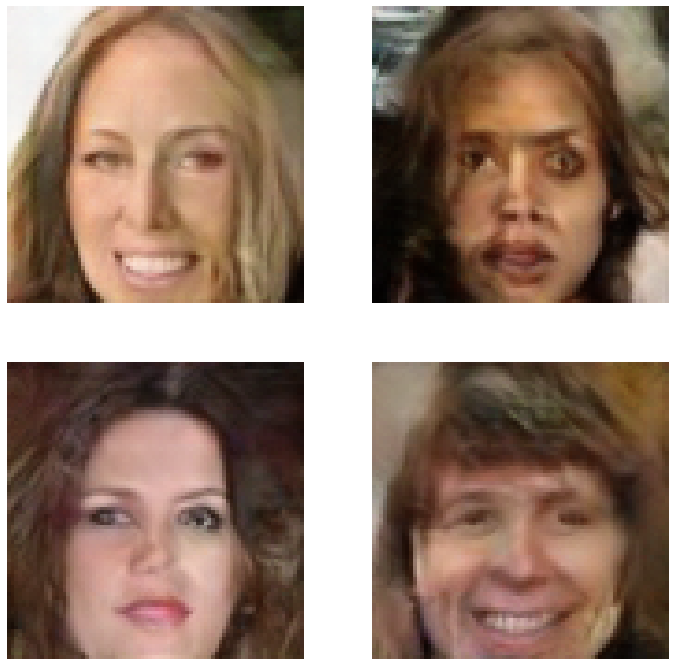

[Epoch 8]: : 1581it [00:38, 44.91it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 8]: : 1582it [00:38, 41.19it/s]


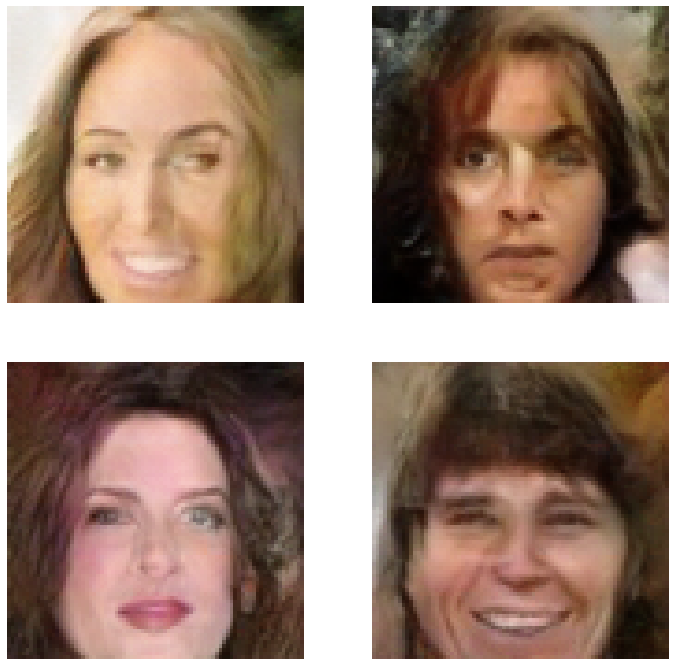

[Epoch 9]: : 1581it [00:38, 43.63it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 9]: : 1582it [00:39, 40.53it/s]


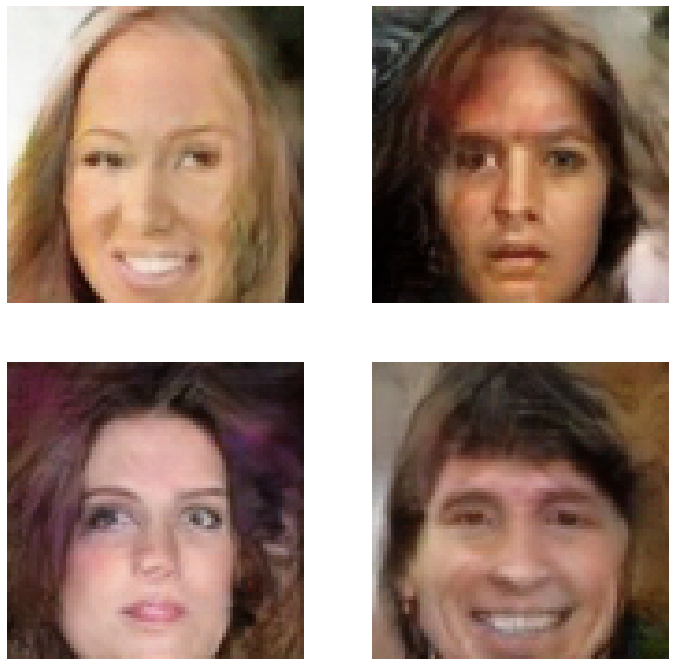

[Epoch 10]: : 1581it [00:39, 44.36it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 10]: : 1582it [00:39, 40.33it/s]


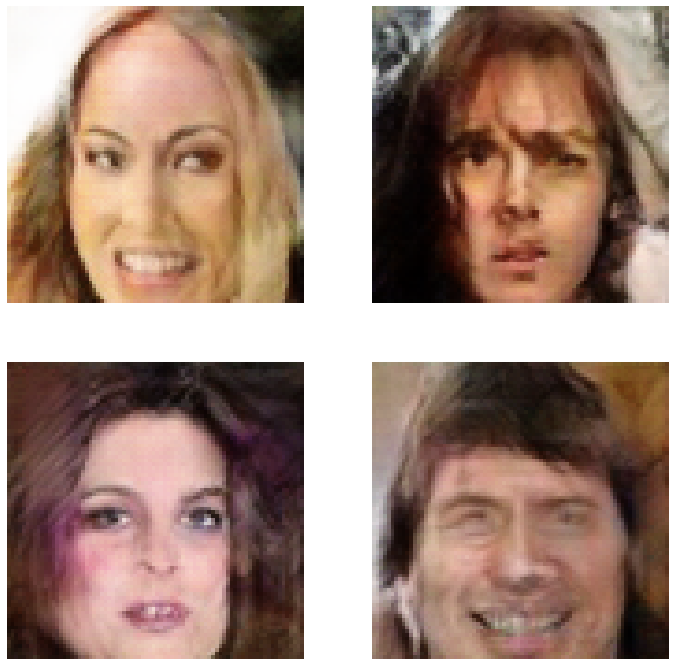

[Epoch 11]: : 1581it [00:39, 44.08it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 11]: : 1582it [00:39, 40.44it/s]


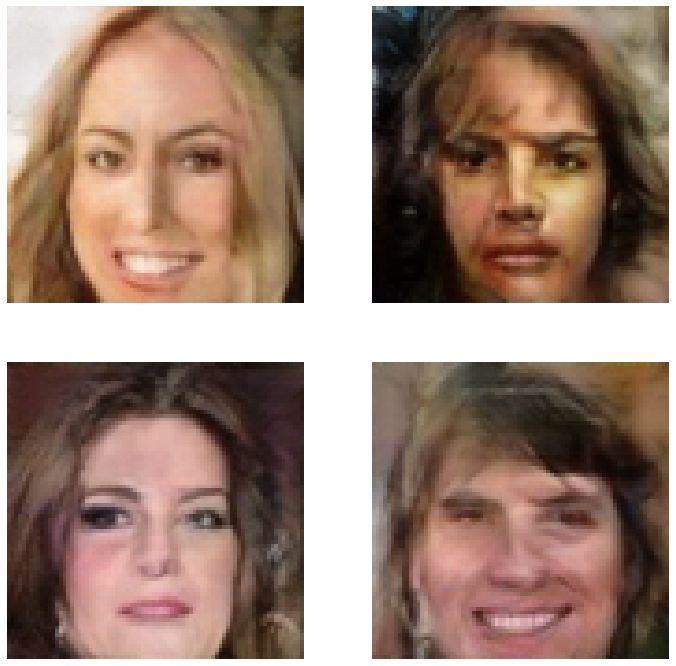

[Epoch 12]: : 1581it [00:38, 44.19it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 12]: : 1582it [00:39, 40.53it/s]


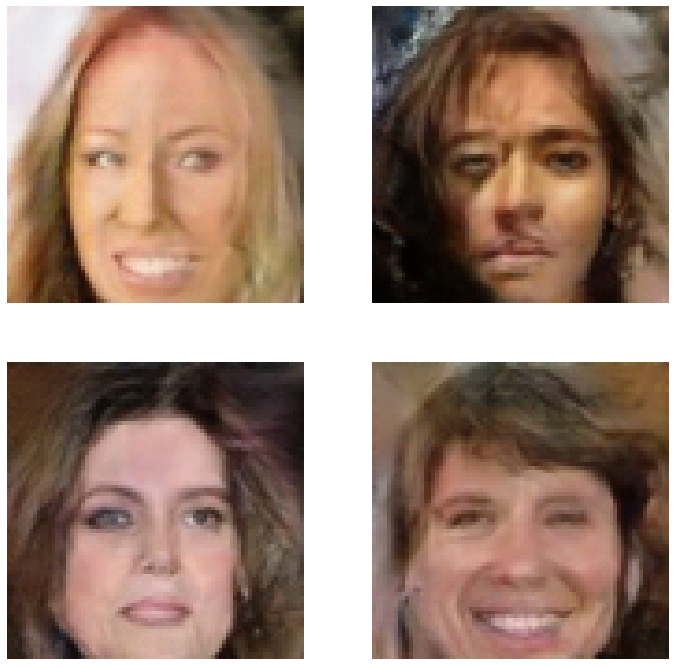

[Epoch 13]: : 1581it [00:38, 46.19it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 13]: : 1582it [00:38, 41.24it/s]


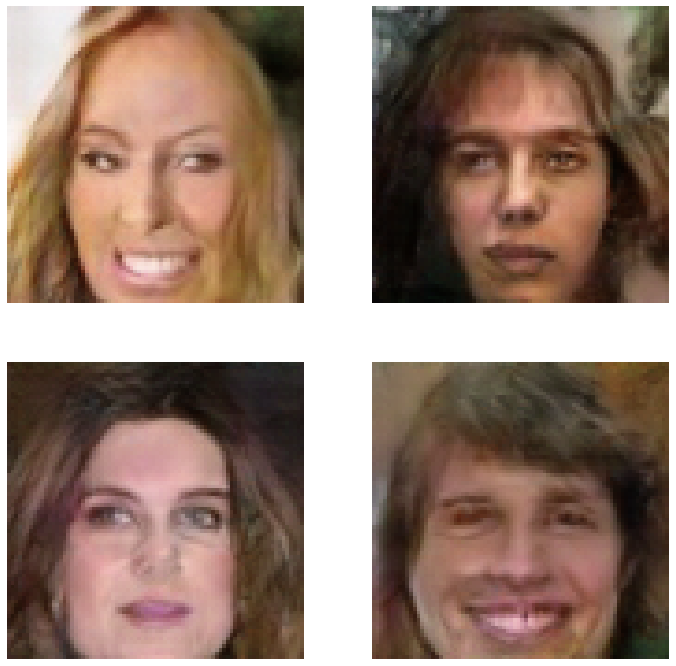

[Epoch 14]: : 1581it [00:38, 43.01it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 14]: : 1582it [00:38, 40.85it/s]


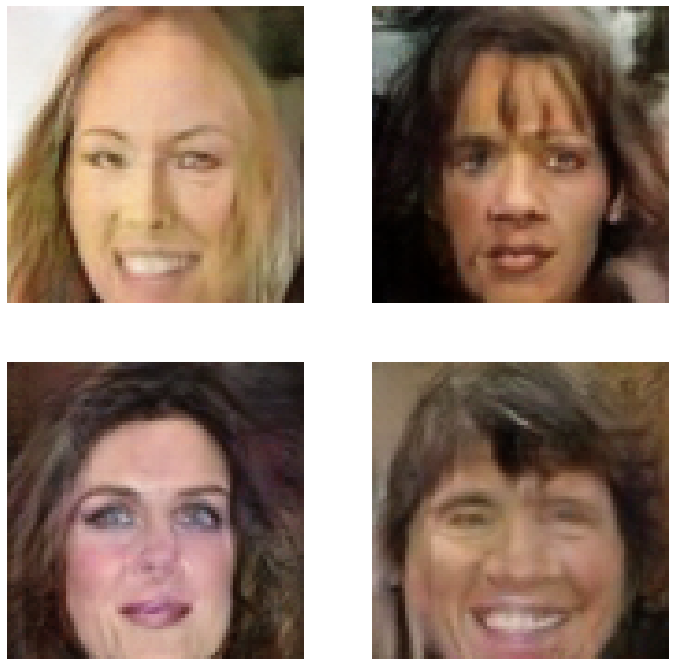

[Epoch 15]: : 1581it [00:38, 43.90it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 15]: : 1582it [00:38, 40.79it/s]


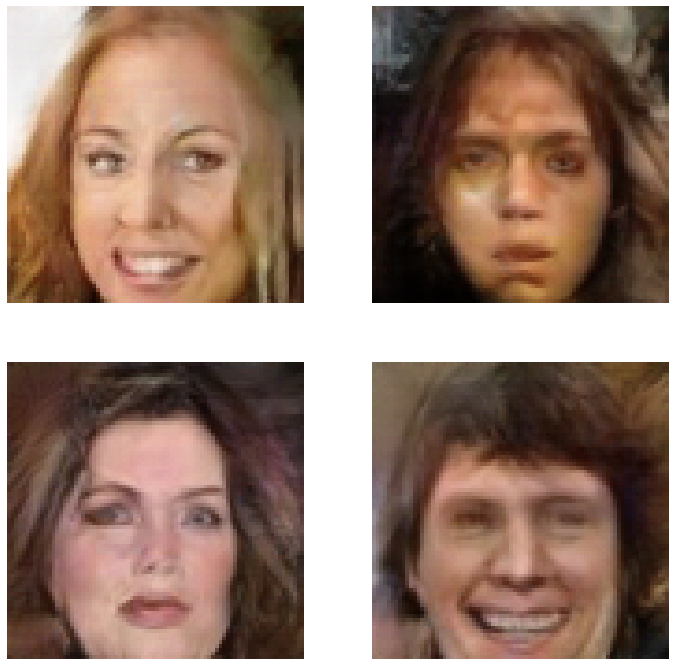

[Epoch 16]: : 1581it [00:38, 44.97it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 16]: : 1582it [00:38, 41.48it/s]


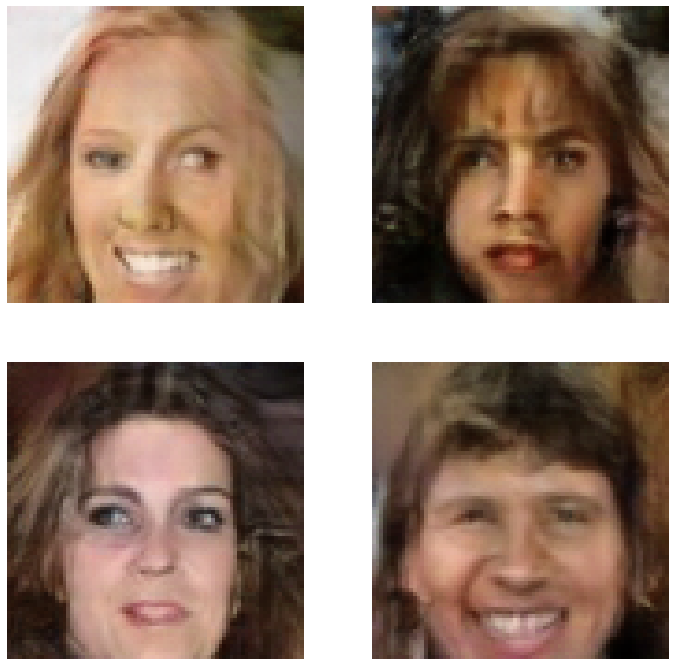

[Epoch 17]: : 1581it [00:38, 42.53it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 17]: : 1582it [00:38, 41.04it/s]


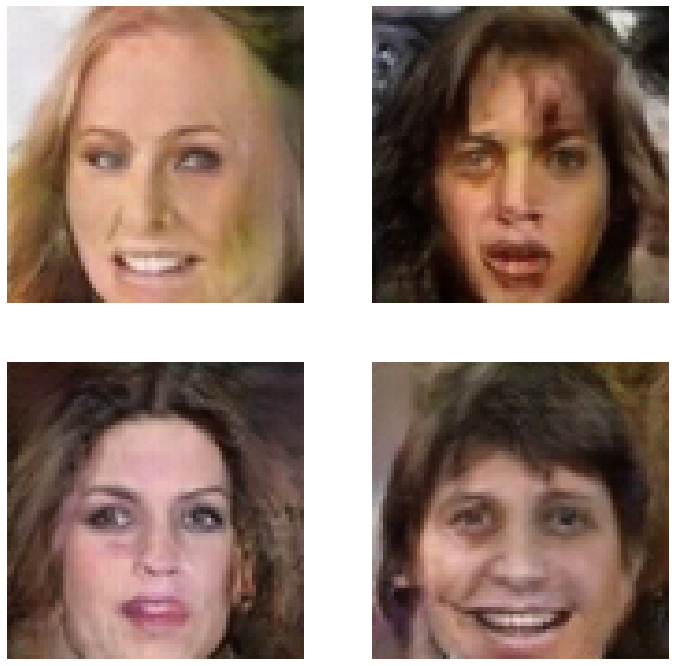

[Epoch 18]: : 1581it [00:38, 43.45it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 18]: : 1582it [00:38, 40.89it/s]


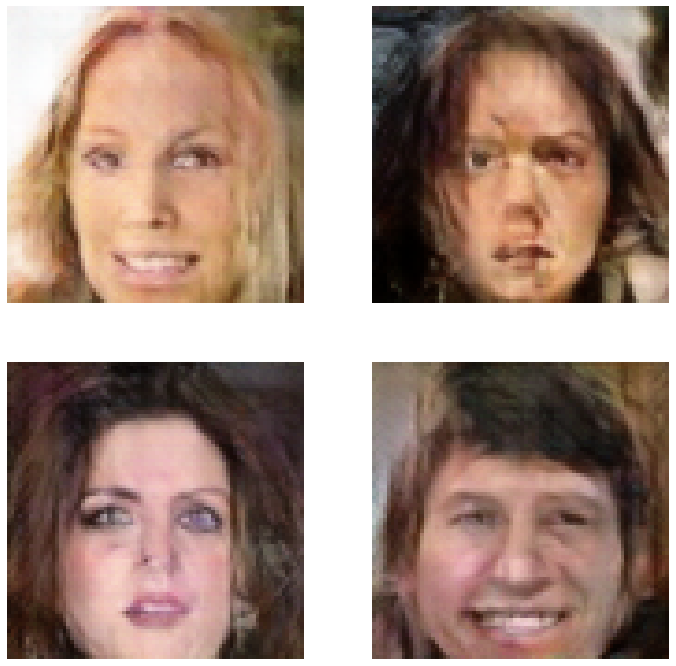

[Epoch 19]: : 1581it [00:38, 45.08it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 19]: : 1582it [00:38, 40.73it/s]


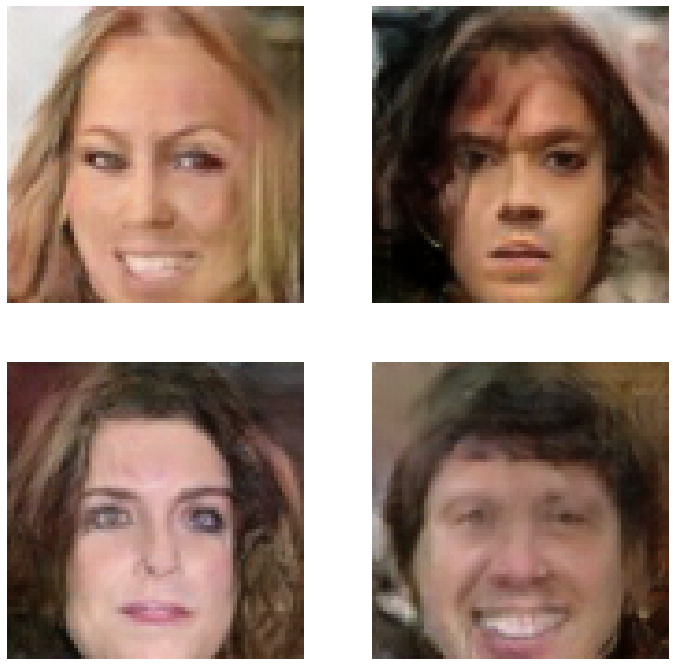

[Epoch 20]: : 1581it [00:38, 44.85it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 20]: : 1582it [00:38, 40.66it/s]


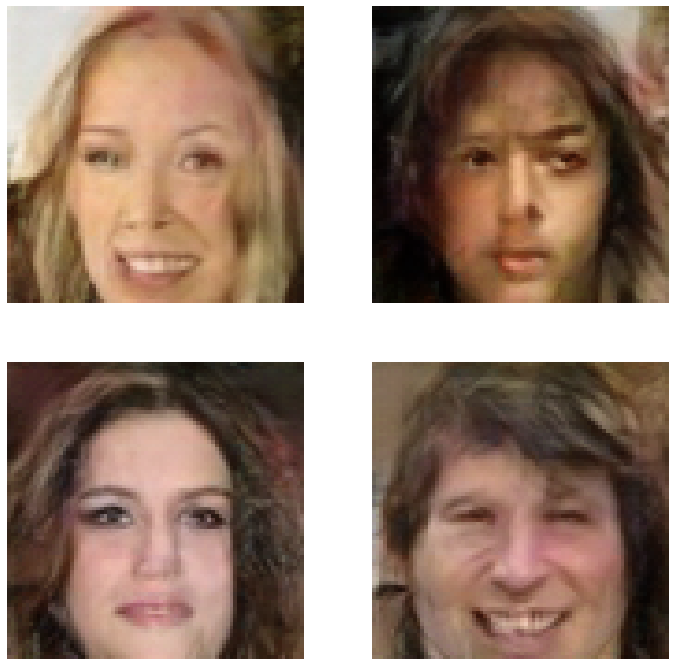

[Epoch 21]: : 1581it [00:38, 43.57it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 21]: : 1582it [00:38, 41.22it/s]


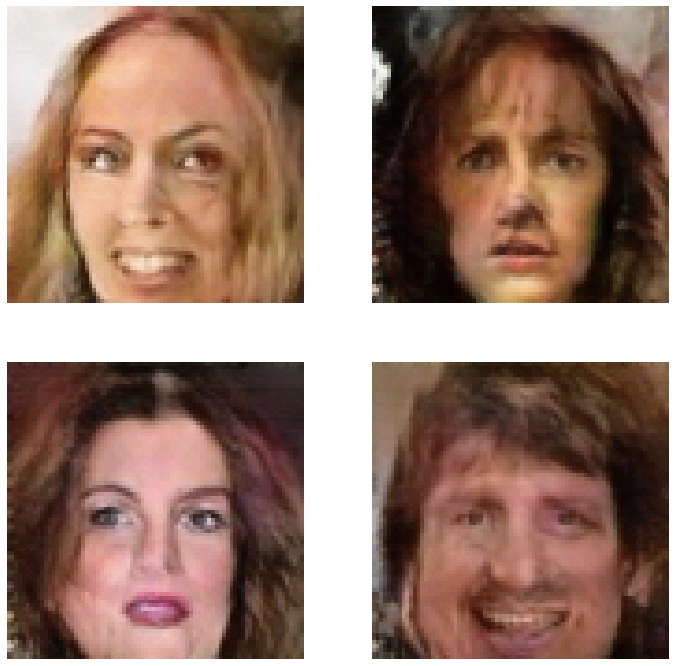

[Epoch 22]: : 1581it [00:38, 45.24it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 22]: : 1582it [00:38, 41.55it/s]


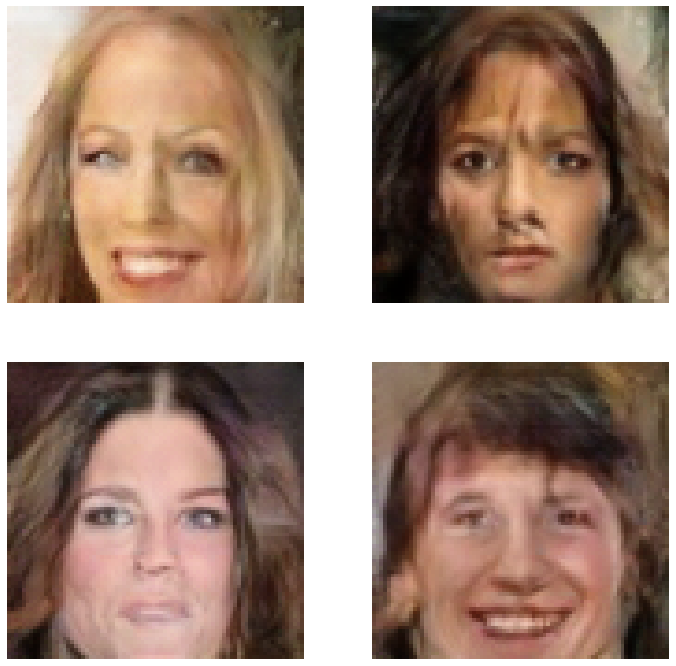

[Epoch 23]: : 1581it [00:38, 45.03it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 23]: : 1582it [00:38, 41.12it/s]


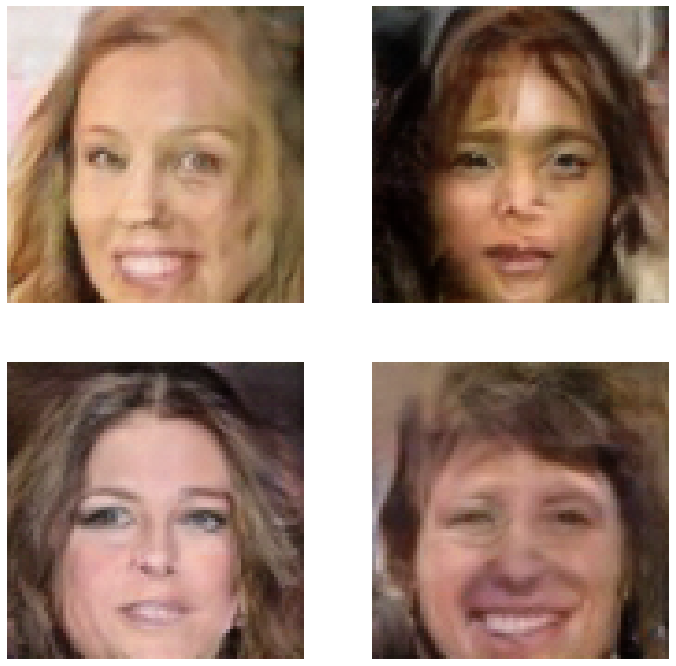

[Epoch 24]: : 1580it [00:38, 45.62it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 24]: : 1582it [00:38, 40.70it/s]


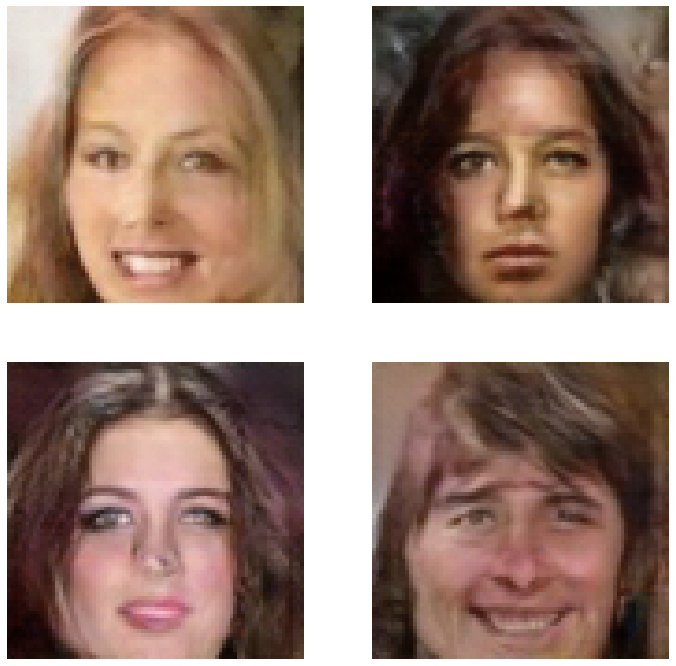

[Epoch 25]: : 1581it [00:38, 43.29it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 25]: : 1582it [00:38, 41.32it/s]


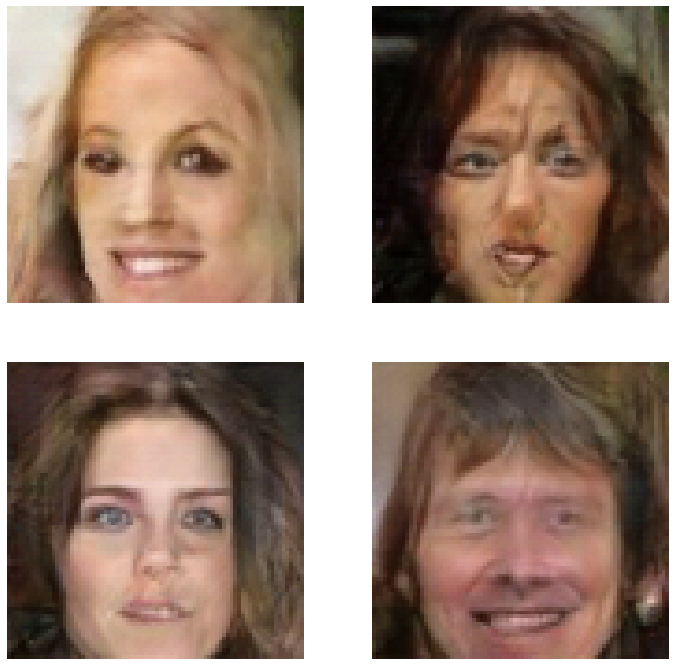

[Epoch 26]: : 1581it [00:38, 42.76it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 26]: : 1582it [00:38, 40.83it/s]


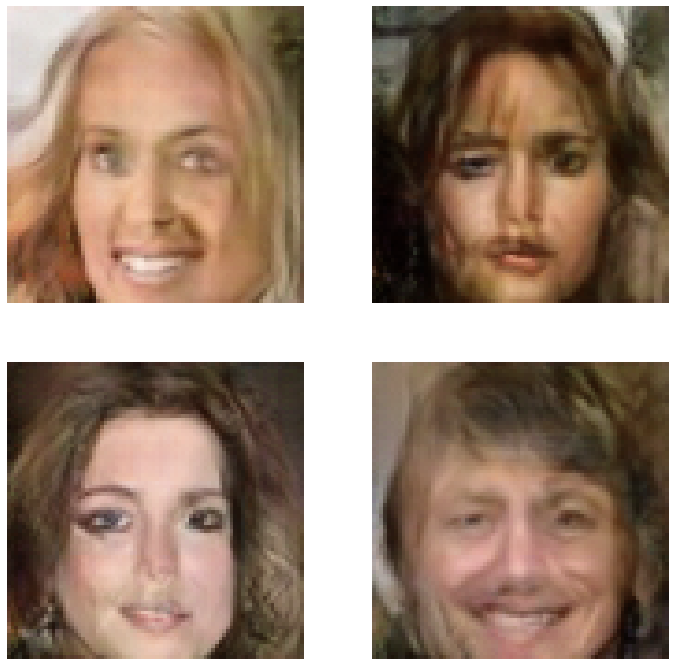

[Epoch 27]: : 1581it [00:39, 44.60it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 27]: : 1582it [00:39, 40.24it/s]


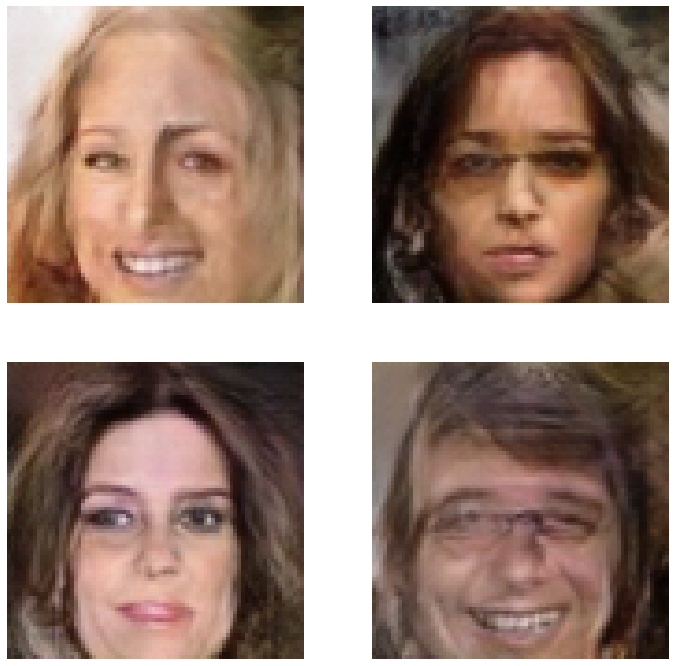

[Epoch 28]: : 1581it [00:38, 44.73it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 28]: : 1582it [00:38, 41.14it/s]


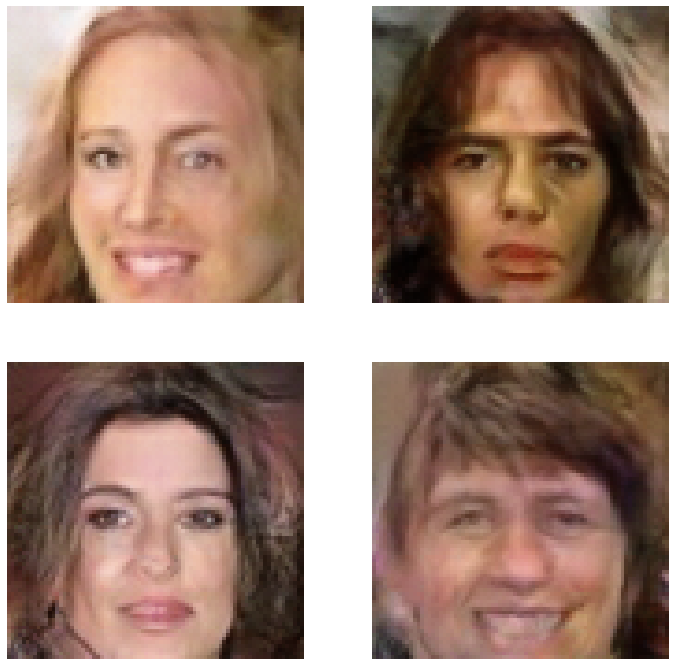

[Epoch 29]: : 1581it [00:38, 44.58it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 29]: : 1582it [00:38, 41.07it/s]


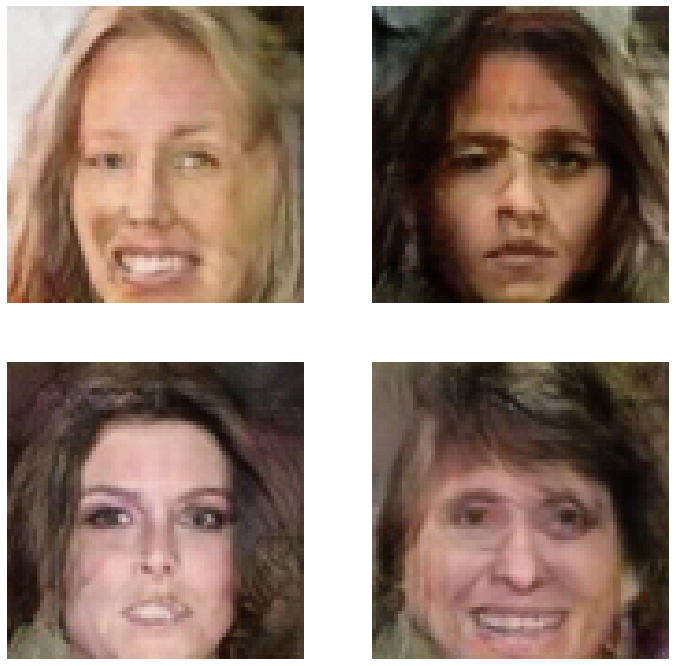

[Epoch 30]: : 1581it [00:37, 45.24it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 30]: : 1582it [00:37, 41.66it/s]


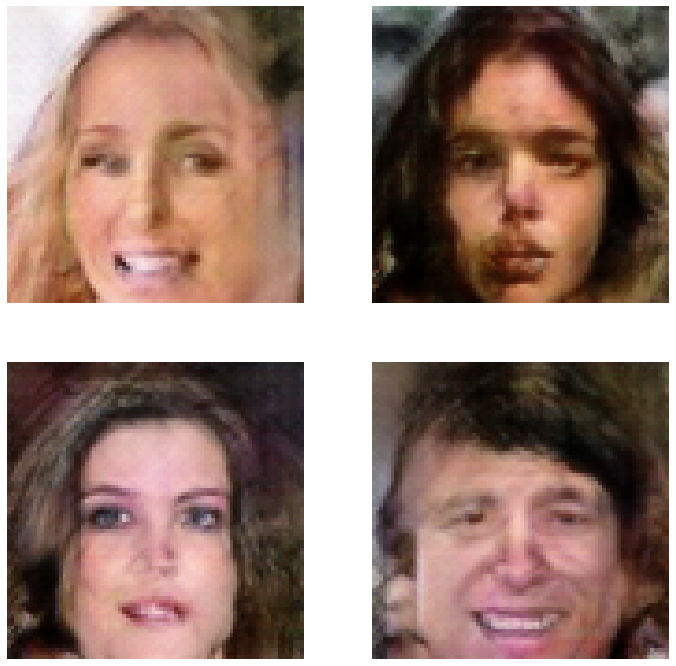

[Epoch 31]: : 1581it [00:38, 43.26it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 31]: : 1582it [00:38, 40.89it/s]


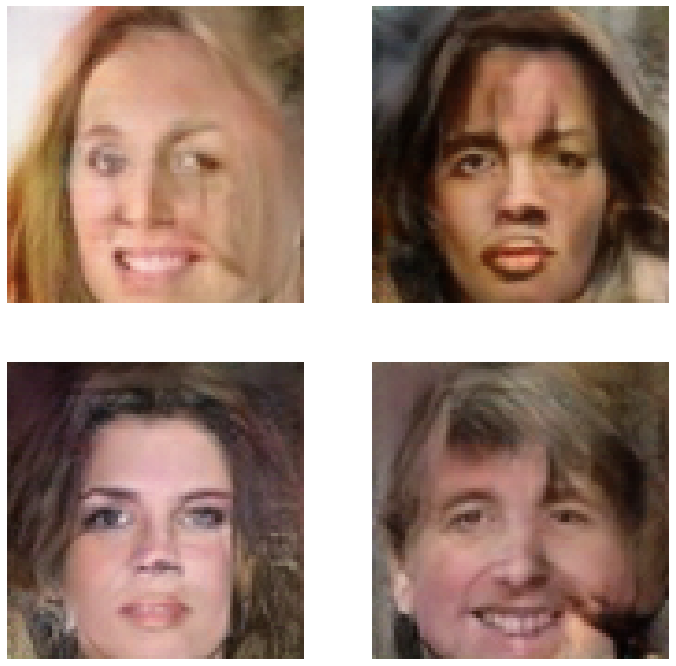

[Epoch 32]: : 1581it [00:38, 44.10it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 32]: : 1582it [00:38, 40.64it/s]


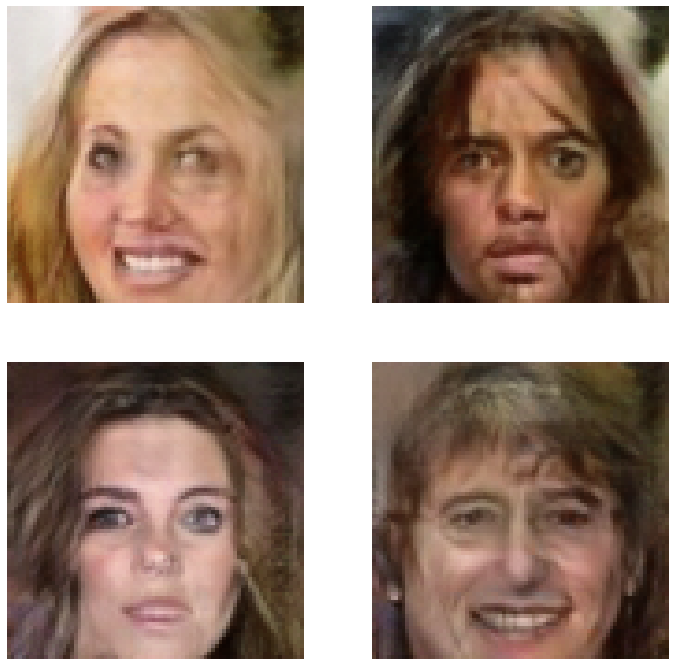

[Epoch 33]: : 1581it [00:39, 43.45it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 33]: : 1582it [00:39, 40.52it/s]


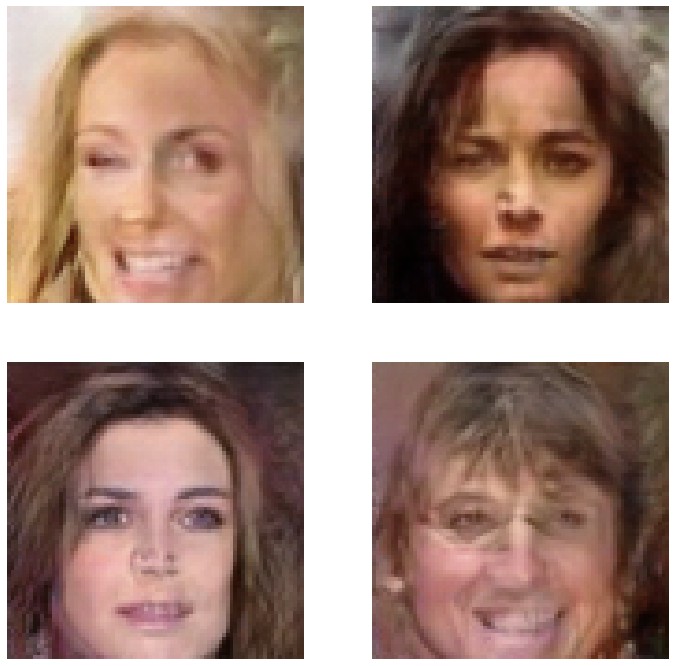

[Epoch 34]: : 1581it [00:39, 42.36it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 34]: : 1582it [00:39, 40.32it/s]


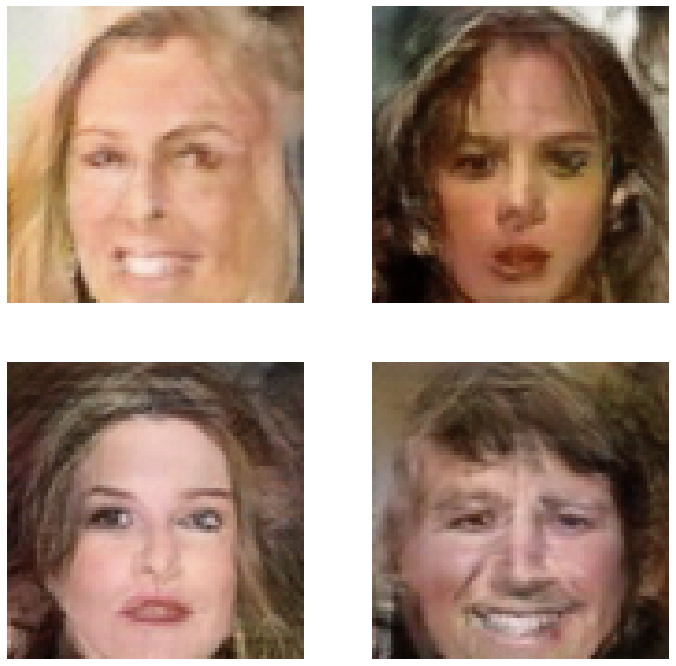

[Epoch 35]: : 1581it [00:38, 44.56it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 35]: : 1582it [00:38, 40.69it/s]


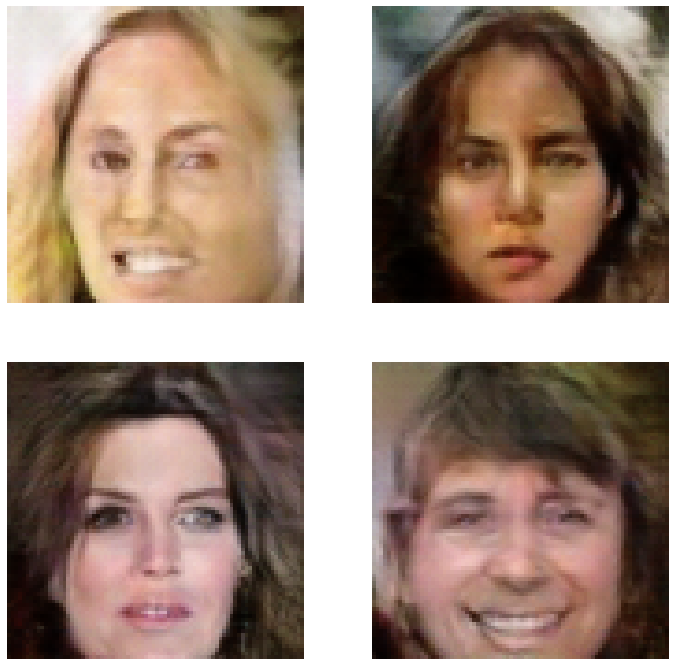

[Epoch 36]: : 1581it [00:39, 41.38it/s]Exception ignored in: <function Executor.__del__ at 0x7faf2e8a30d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
[Epoch 36]: : 1582it [00:39, 39.91it/s]


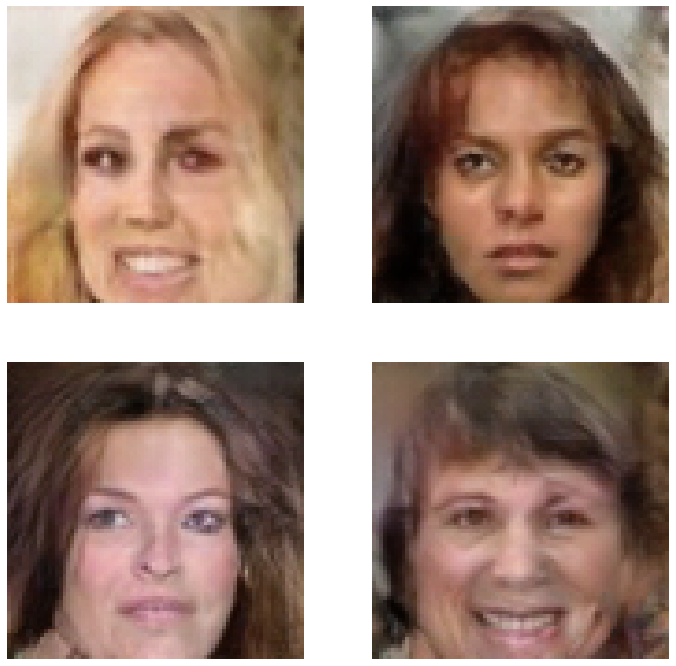

[Epoch 37]: : 0it [00:00, ?it/s]

In [ ]:

NUM_EPOCHS = 100

# generate a batch of noisy input
z_dim = 128
test_z = tf.random.normal(shape=(64, 1, 1, z_dim))

# start loop
tf.keras.backend.clear_session()
for epoch in range(NUM_EPOCHS): 
    with tqdm(dataset) as pbar:
        pbar.set_description(f"[Epoch {epoch}]")
        for step, (X1, X2) in enumerate(pbar):
            # train on the current batch
            d_loss, g_loss, fake = train_on_batch(X1, X2)
    
        # generate fake images
        fake_img = model_G(test_z)

    # save face generated to file. 
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    file_path = out_dir+f"/epoch_{epoch:04}.png"
    
    # display gallery of generated faces
    if epoch % 1 == 0:
        plot_results(fake_img.numpy()[:4], 2, save_path=file_path)


## Display GIF sample results

You can run the cells below to display the galleries as an animation. 

In [ ]:
from PIL import Image
imgs = os.listdir('celeba_out')
imgs.sort()
gif_images = []
for img in imgs: 
  if img.find("png")>0:
    print ("celebaout/" + img)
    
    with Image.open("celeba_out/" + img) as im:
      im = im.convert("RGB")
      gif_images.append(np.array(im))
gif_path = "faces.gif"
imageio.mimsave(gif_path, gif_images, fps=1)



celebaout/epoch_0000.png
celebaout/epoch_0010.png
celebaout/epoch_0020.png
celebaout/epoch_0030.png
celebaout/epoch_0040.png
celebaout/epoch_0050.png
celebaout/epoch_0060.png
celebaout/epoch_0070.png
celebaout/epoch_0080.png
celebaout/epoch_0090.png


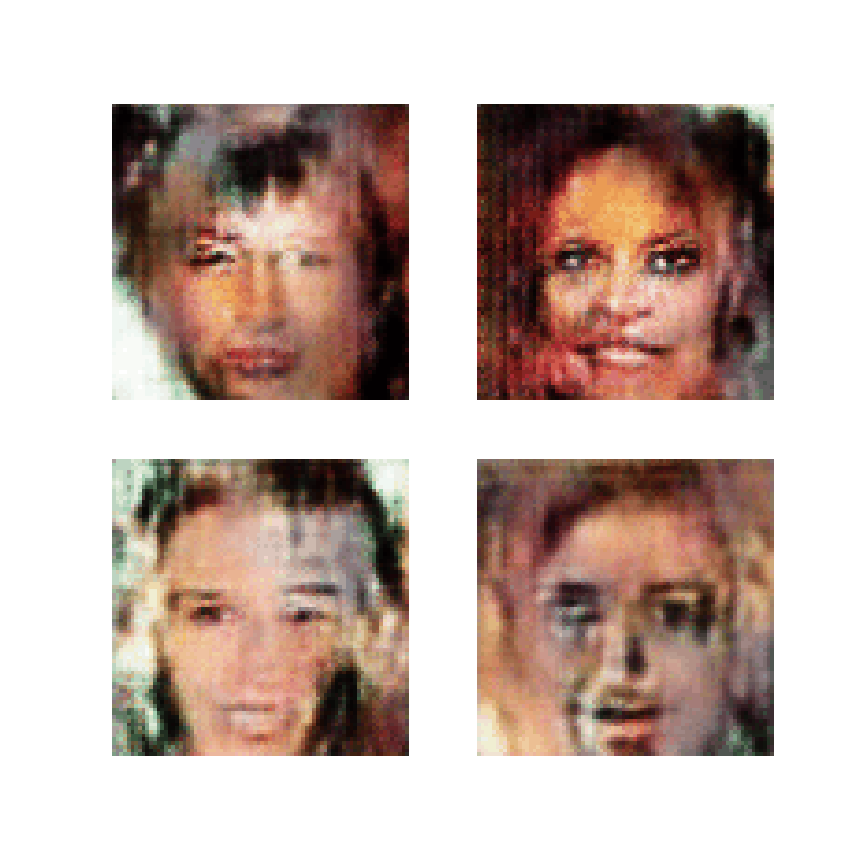

In [ ]:
path="faces.gif"

with open(path,'rb') as f:
    display(IpyImage(data=f.read(), format='png'))

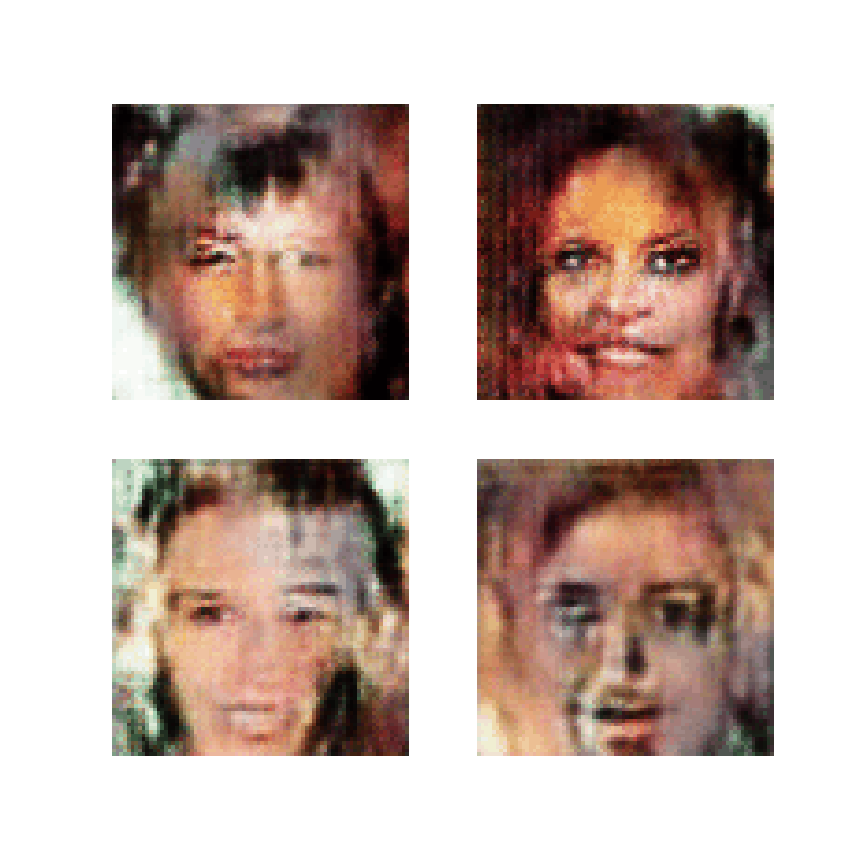

In [ ]:
from IPython.display import Image
gif_path = "faces.gif"
Image(filename=gif_path)

**Congratulations on completing the final ungraded lab for this course!**